# Проект "CLIP-Guided Domain Adaptation of Image Generators"

Данный проект представляет собой имплементацию подхода StyleGAN-NADA, предложенного в статье [StyleGAN-NADA: CLIP-Guided Domain Adaptation of Image Generators](https://arxiv.org/pdf/2108.00946).
Представленный ниже функционал предназначен для визуализации реализованного проекта и включает в себя:
- Сдвиг генератора по текстовому промпту
- Генерация примеров
- Генерация примеров из готовых пресетов
- Веб-демо
- Стилизация изображения из файла


## 1. Установка

In [1]:
# @title
# Импорт нужных библиотек
import os
import sys
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Настройка устройства
device = "cuda" if torch.cuda.is_available() else "cpu"

# Класс для подавления вывода
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

suppress = SuppressOutput()

# Подготовка шагов для общего прогресса
steps = [
    "Установка библиотек",
    "Клонирование репозитория StyleGAN2",
    "Скачивание весов StyleGAN",
    "Загрузка генератора"
]

# Инициализация общего прогресса
with tqdm(total=len(steps), desc="Выполнение шагов") as pbar:
    # Установка библиотек
    pbar.set_description(steps[0])
    with suppress:
        !pip install ftfy regex tqdm
        !pip install git+https://github.com/openai/CLIP.git
        !pip install Ninja
    pbar.update(1)

    # Клонирование репозитория StyleGAN2
    pbar.set_description(steps[1])
    with suppress:
        !git clone https://github.com/rosinality/stylegan2-pytorch.git
        os.chdir("stylegan2-pytorch")
    pbar.update(1)

    # Скачивание весов StyleGAN
    pbar.set_description(steps[2])
    with suppress:
        !pip install gdown
        !gdown https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
        !gdown https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL
    pbar.update(1)

    # Импорт генератора из репозитория
    pbar.set_description(steps[3])
    from model import Generator

    # Параметры генератора
    latent_dim = 512
    f_generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
    state_dict = torch.load('stylegan2-ffhq-config-f.pt', map_location=device)
    f_generator.load_state_dict(state_dict['g_ema'])
    f_generator.eval()

    g_generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
    g_generator.load_state_dict(state_dict['g_ema'])
    pbar.update(1)

# Загрузка модели CLIP
import clip
clip_model, preprocess = clip.load("ViT-B/32", device=device)

Загрузка генератора: 100%|██████████| 4/4 [02:04<00:00, 31.16s/it]
100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 183MiB/s]


## 2. Ввод параметров

In [2]:
source_domain = "Photo" # @param {"type":"string"}
target_domain = "Sketch" #@param {"type": "string"}
num_steps = 200 #@param {"type": "integer"}

## 3. Оптимизация

In [3]:
# @title
with torch.no_grad():
    # Преобразование текста в тензоры
    source_tokens = clip.tokenize([source_domain]).to(device)
    target_tokens = clip.tokenize([target_domain]).to(device)

    # Получение эмбеддингов текста
    source_embedding = clip_model.encode_text(source_tokens)
    source_embedding = source_embedding / source_embedding.norm(dim=-1, keepdim=True)  # Нормализация

    target_embedding = clip_model.encode_text(target_tokens)
    target_embedding = target_embedding / target_embedding.norm(dim=-1, keepdim=True)  # Нормализация

    # Расчет направления
    direction = (target_embedding - source_embedding).detach()

# Определение потерь для CLIP
class DirectionalCLIPLoss(nn.Module):
    def __init__(self, stylegan_size=1024):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=7)  # Увеличение разрешения
        self.avg_pool = nn.AvgPool2d(kernel_size=stylegan_size // 32)  # Сглаживание

    def forward(self, source_images, target_images):
        source_images = self.avg_pool(self.upsample(source_images))
        source_features = clip_model.encode_image(source_images)
        source_features = source_features / source_features.norm(dim=-1, keepdim=True)

        target_images = self.avg_pool(self.upsample(target_images))
        target_features = clip_model.encode_image(target_images)
        target_features = target_features / target_features.norm(dim=-1, keepdim=True)

        delta_features = target_features - source_features
        loss = 1 - torch.cosine_similarity(delta_features, direction, dim=-1).mean()
        return loss

class CLIPLoss(nn.Module):
    def __init__(self, stylegan_size=1024):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=7)
        self.avg_pool = nn.AvgPool2d(kernel_size=stylegan_size // 32)

    def forward(self, image):
        image = self.avg_pool(self.upsample(image))
        image_features = clip_model.encode_image(image)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        loss = 1 - torch.cosine_similarity(image_features, target_embedding, dim=-1).mean()
        return loss

# Фаза 1: Оптимизация латентных кодов

# Заморозка/разморозка слоев модели
def freeze(layers, flag=False):
    for l in layers:
        for p in l.parameters():
          p.requires_grad = flag

latent_dim=512
batch_size=4

freeze(f_generator.children(), False)

w = f_generator.style(torch.randn(batch_size, latent_dim).to(device))
w = w.unsqueeze(1).repeat(1, f_generator.n_latent, 1).clone()
w_plus = torch.Tensor(w.cpu().detach().numpy()).to(device)
w_plus.requires_grad = True

optimizer = torch.optim.Adam([w_plus], lr=1e-2)
clip_loss_fn = CLIPLoss()

# Цикл оптимизации
for step in tqdm(range(100)):
    optimizer.zero_grad()

    img_gen = f_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]

    loss = clip_loss_fn(img_gen)
    loss.backward()

    optimizer.step()

    #if step % 100 == 0:
    #    print(f"Step {step}, Loss: {loss.item()}")

# Анализ изменений в W+
w_changes = torch.abs(w_plus - w).mean(dim=-1).mean(dim=0)
layer_ids = np.argsort(w_changes.cpu().detach().numpy())[-12:]

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


## 4. Обучение

In [15]:
# @title
# Обучение
g_generator.train()
freeze(g_generator.children(), False)

# Фаза 2: Разморозка слоёв и тренировка
for name, param in g_generator.named_parameters():
    if "convs" in name:  # Ограничимся слоями конволюций
        layer_id = int(name.split(".")[1])  # Извлечение индекса слоя
        param.requires_grad = bool(layer_id in layer_ids)

w_plus.requires_grad = False

# Оптимизатор для выбранных слоёв
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, g_generator.parameters()), lr=5e-3)
loss_fn = DirectionalCLIPLoss()

for step in tqdm(range(num_steps)):

    # Генерация изображений исходного домена (замороженный генератор)
    with torch.no_grad():
        w_optimized = f_generator.style(torch.randn(batch_size, latent_dim).to(device))
        w_plus = w_optimized.unsqueeze(1).repeat(1, f_generator.n_latent, 1).clone()
        source_images = f_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]

    # Генерация изображений целевого домена (обновляемый генератор)
    target_images = g_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]

    loss = loss_fn(source_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #if step % 100 == 0:
    #    print(f"Step {step}, Directional CLIP Loss: {loss.item()}")

100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


## 5. Генерация примеров

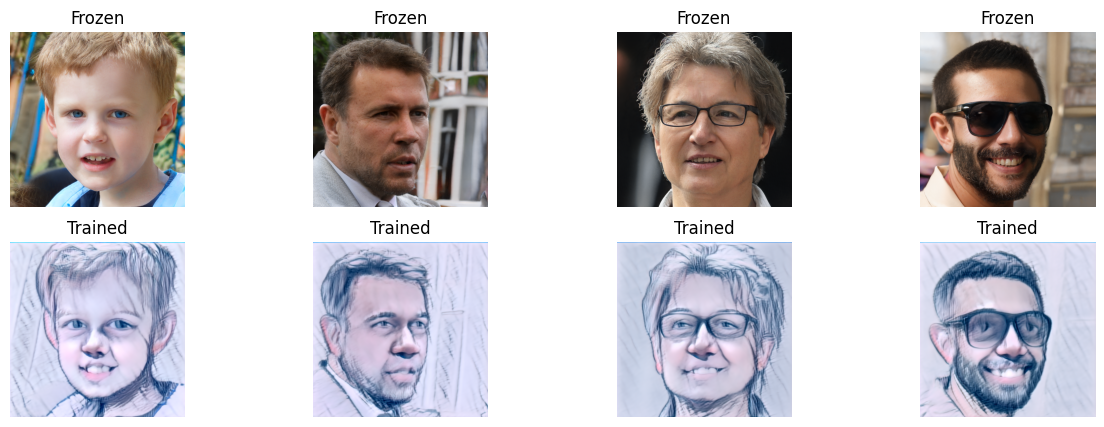

In [18]:
# @title
def generate_and_display_images(g_generator):
    with torch.no_grad():
        w_optimized = f_generator.style(torch.randn(batch_size, latent_dim).to(device))
        w_plus = w_optimized.unsqueeze(1).repeat(1, f_generator.n_latent, 1).clone()

        frozen_images = f_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]
        frozen_images = (frozen_images.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
        frozen_images = frozen_images.permute(0, 2, 3, 1).cpu().numpy()

        trained_images = g_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]
        trained_images = (trained_images.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
        trained_images = trained_images.permute(0, 2, 3, 1).cpu().numpy()

    # Отображение изображений
    num_images = batch_size
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Замороженный генератор
        plt.subplot(2, num_images, i + 1)
        plt.imshow(frozen_images[i])
        plt.axis('off')
        plt.title("Frozen")

        # Обученный генератор
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(trained_images[i])
        plt.axis('off')
        plt.title("Trained")
    plt.show()


# Генерация и отображение изображений
generate_and_display_images(g_generator)

## 6. Готовые пресеты

In [7]:
# @title Загрузка пресетов
print('Загрузка моих пресетов...')
os.makedirs("/content/presets", exist_ok=True)
with suppress:
    !gdown --output /content/presets/sketch.pth https://drive.google.com/uc?id=1trcBvlz7jeBRLNeCyNVCXE4esW25GPaZ
    !gdown --output /content/presets/modigliani.pth https://drive.google.com/uc?id=1N4C-aTwxeOamZX2GeEElppsMv-ALKojL
    !gdown --output /content/presets/werewolf.pth https://drive.google.com/uc?id=1VZHEalFyEFGWIaHei98f9XPyHHvMBp6J
print('Пресеты (3) успешно загружены')

Загрузка моих пресетов...


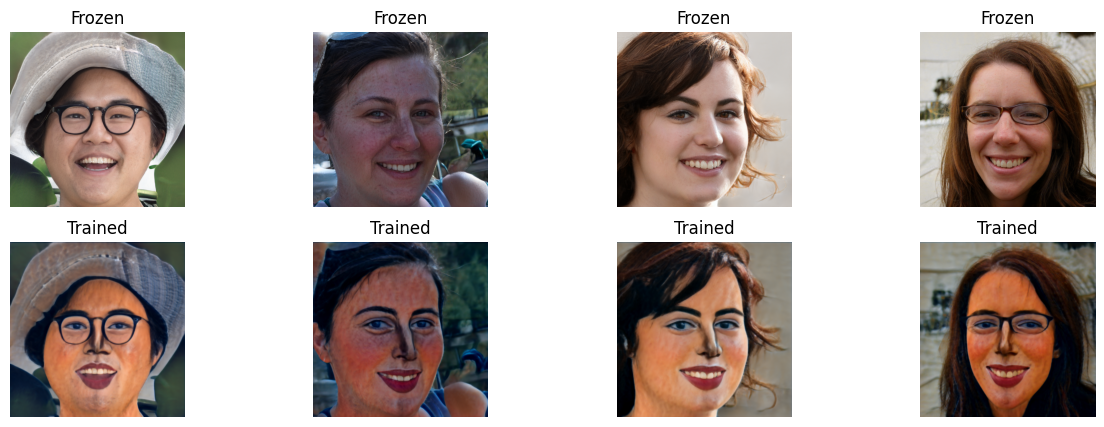

In [11]:
# @title Генерация примеров из пресета
# Загрузка генератора из файла
def load_model(file_path, latent_dim=512, size=1024):

    state_dicts = torch.load(file_path, map_location=device)

    # Инициализация
    trained_generator = Generator(size=size, style_dim=latent_dim, n_mlp=8).to(device)

    # Загрузка весов
    trained_generator.load_state_dict(state_dicts)

    trained_generator.eval()

    return trained_generator

model_paths = {
    "Photo -> Pencil Sketch": "/content/presets/sketch.pth",
    "Photo -> Modigliani Painting": "/content/presets/modigliani.pth",
    "Human -> Werewolf": "/content/presets/werewolf.pth"
}

# Выбор модели
preset = 'Photo -> Modigliani Painting'  # @param ["Photo -> Pencil Sketch", "Photo -> Modigliani Painting", "Human -> Werewolf"]

# Загрузка пути к файлу выбранной модели
model_path = model_paths[preset]

# Генерация и отображение изображений
generate_and_display_images(load_model(model_path))


## 8. Веб-демо

In [ ]:
# @title
with suppress:
  !pip install gradio

import gradio as gr

# Функция обработки
def generate(model_name):
    model_path = model_paths[model_name]
    g_generator = load_model(model_path)
    images = []
    with torch.no_grad():
        w_optimized = f_generator.style(torch.randn(2, latent_dim).to(device))
        w_plus = w_optimized.unsqueeze(1).repeat(1, f_generator.n_latent, 1).clone()

        frozen_images = f_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]
        frozen_images = (frozen_images.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
        frozen_images = frozen_images.permute(0, 2, 3, 1).cpu().numpy()
        images.extend(frozen_images)
        trained_images = g_generator(w_plus.unsqueeze(0), input_is_latent=True)[0]
        trained_images = (trained_images.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
        trained_images = trained_images.permute(0, 2, 3, 1).cpu().numpy()
        images.extend(trained_images)
    return images

# Интерфейс
iface = gr.Interface(
    fn=generate,
    inputs=gr.Dropdown(choices=list(model_paths.keys()), label="Выберите пресет"),
    outputs=gr.Gallery(label="Результаты генерации", columns=2),
    title="Выбор модели",
    description="Выберите преобразование из списка."
)

iface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e185f5ab38affd27f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Обработка изображения

In [12]:
# @title Загрузка модели инверсии
with suppress:
  !git clone https://github.com/yuval-alaluf/restyle-encoder.git "/content/restyle/"
  %cd "/content/restyle/"

  from argparse import Namespace
  from restyle.utils.common import tensor2im
  from restyle.models.e4e import e4e

  model_file = "restyle_e4e_ffhq_encode.pt"
  !gdown --output /content/restyle/restyle_e4e_ffhq_encode.pt https://drive.google.com/uc?id=1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e

  ckpt = torch.load(model_file, map_location='cpu')

  opts = ckpt['opts']

  opts['checkpoint_path'] = model_file
  opts = Namespace(**opts)

  restyle_net = (e4e)(opts)

  restyle_net.eval()
  restyle_net.cuda()
print('Модель успешно загружена')

Downloading...
From (original): https://drive.google.com/uc?id=1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e
From (redirected): https://drive.google.com/uc?id=1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e&confirm=t&uuid=139d5eb8-556c-4b48-91f2-09dc9b263c96
To: /content/restyle/restyle_e4e_ffhq_encode.pt
100% 959M/959M [00:07<00:00, 121MB/s]
Loading ReStyle e4e from checkpoint: restyle_e4e_ffhq_encode.pt
Модель успешно загружена


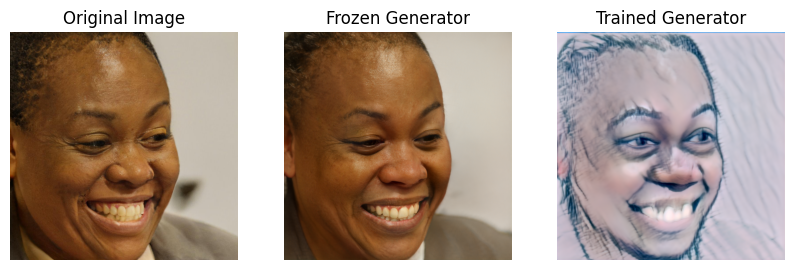

In [19]:
# @title Стилизация изображения из файла

image_path = "/content/image.jpg" #@param {'type': 'string'}

# Загрузка изображения
original_image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_image = transform(original_image).unsqueeze(0).to(device)

def get_avg_image(net):
    avg_image = net(net.latent_avg.unsqueeze(0),
                    input_code=True,
                    randomize_noise=False,
                    return_latents=False,
                    average_code=True)[0]
    avg_image = avg_image.to('cuda').float().detach()
    return avg_image

opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution

from restyle.utils.inference_utils import run_on_batch

with torch.no_grad():
    avg_image = get_avg_image(restyle_net)
    result_batch, result_latents = run_on_batch(input_image, restyle_net, opts, avg_image)

inverted_latent = torch.Tensor(result_latents[0][4]).cuda().unsqueeze(0).unsqueeze(1)

with torch.no_grad():
    sampled_src = f_generator(inverted_latent, input_is_latent=True)[0]
    frozen_image = (sampled_src.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
    frozen_image = frozen_image.permute(0, 2, 3, 1).cpu().numpy()

    g_generator.eval()

    sampled_src = g_generator(inverted_latent, input_is_latent=True)[0]
    trained_image = (sampled_src.clamp(-1, 1) + 1) / 2.0  # Нормализация к [0, 1]
    trained_image = trained_image.permute(0, 2, 3, 1).cpu().numpy()

# Отображение результатов
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(Image.open(image_path))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Frozen Generator")
plt.imshow(frozen_image.squeeze(0))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Trained Generator")
plt.imshow(trained_image.squeeze(0))
plt.axis("off")

plt.show()